<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/c/ce/Huberlin-logo.svg/200px-Huberlin-logo.svg.png" alt="fff" align="left" style="width: 150px;width: 150px;align:left">


# Recurrent Encoder-Decoder Model (RED)
 
#### Thesis: Neural response generation for email conversations
#### Author: Sydney Richards
#### Required Runtime: GPU
#### Tensorflow version required 2.x
#### Estimated Runtime: ~4h

This notebook contains the complete set up of the RED model used in the thesis. All results related to the RED model have been developed with this workbook.
This workbook can be used for both the English as well as the German data set.
However, the default set up is for the English data otherise all references to 
the dataframe "data" have to be replaced with "dataDE".





In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf
#import tensorflow_hub as hub
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import io
import time
import datetime as dt
import pandas as pd


seed = np.random.RandomState(seed=10)

TensorFlow 2.x selected.


### Stanford NER Tagger

Stanford NER is a Java implementation of a Named Entity Recognizer. Named Entity Recognition (NER) labels sequences of words in a text which are the names of things, such as person and company names, or gene and protein names. It comes with well-engineered feature extractors for Named Entity Recognition, and many options for defining feature extractors. Included with the download are good named entity recognizers for English and German, particularly for the 3 classes (PERSON, ORGANIZATION, LOCATION).

We use the Tagger to itdentify names and replace them with tokens, since we do not wan't our model to have to remember names just add a token at the position of the sentence were a name should appear. 

[Stanford NLP Reference](https://nlp.stanford.edu/software/CRF-NER.shtml)

In [0]:
!pip install glove_python -q
!pip install rouge -q
!pip install nltk --upgrade

     |████████████████████████████████| 266kB 4.8MB/s 
     |████████████████████████████████| 1.5MB 4.9MB/s 
  Created wheel for nltk: filename=nltk-3.4.5-cp36-none-any.whl size=1449906 sha256=c4f8cc927e6537b853f1411f764bc5bcc351a174f9fa240cf01957530d20054e
  Stored in directory: /root/.cache/pip/wheels/96/86/f6/68ab24c23f207c0077381a5e3904b2815136b879538a24b483
Successfully built nltk
  Found existing installation: nltk 3.2.5
    Uninstalling nltk-3.2.5:
      Successfully uninstalled nltk-3.2.5


In [0]:
!pip install stanfordcorenlp

In [0]:
import nltk

#!wget 'https://nlp.stanford.edu/software/stanford-corenlp-full-2018-10-05.zip'
#!unzip stanford-corenlp-full-2018-10-05

nltk.download('punkt')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
## text = 'Guangdong University is eine Auslandsschule. ' \
##       'Mein Gott der Niklas is ja dick geworden. '

##props={'annotators': 'ner','pipelineLanguage':'de','outputFormat':'json'}


In [0]:
from google.colab import drive

drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


### Load and Merge Datasets

Data sets are tables of e-mail activities where each activity represents a single mail either from customer to the company or vice versa. In order to link
customer enquiries and customer support responses we use the Case ID which is an unique ID given to a e-mail thread of a customer. Each customer can have multiple threads or cases and each case can have mutiple e-mails from both the customer as well as the company but the thread will usually deal with a single issue e.g. "Could ou please check if I have outstanding bills on my  acccount." 

In [0]:
### Self-Join tables over Case_ID 

## EN
activities = pd.read_csv('/content/drive/My Drive/Master Thesis/act_in_out_API.csv') 
activities = pd.merge(activities.loc[activities['ACTIVITY_MODE']=='inbound',['CASE_ID','CONTENT_TEXT','CLASSIFICATIONS']],
                      activities.loc[activities['ACTIVITY_MODE']=='outbound',['CASE_ID','CONTENT_TEXT','CLASSIFICATIONS']],
                      how='inner',left_on='CASE_ID',right_on = 'CASE_ID')

activities2 = pd.read_csv('/content/drive/My Drive/Master Thesis/act_in_out.csv')
activities2 = pd.merge(activities2.loc[activities2['ACTIVITY_MODE']==100,['CASE_ID','CONTENT_TEXT']],
                       activities2.loc[activities2['ACTIVITY_MODE']==200,['CASE_ID','CONTENT_TEXT']],
                       how='inner',left_on='CASE_ID',right_on = 'CASE_ID')

data = pd.concat([activities,activities2],sort=False)
data = data.loc[(data['CONTENT_TEXT_x'].isnull()==False)&(data['CONTENT_TEXT_y'].isnull()==False),:]
data = data.reset_index(drop=True)
data = data.rename({'CONTENT_TEXT_x':'Incoming','CONTENT_TEXT_y':'Outgoing'},axis=1)

## DE
activities_de = pd.read_csv('/content/drive/My Drive/Master Thesis/act_in_out_API_de.csv')
activities_de = pd.merge(activities_de.loc[activities_de['ACTIVITY_MODE']=='inbound',['CASE_ID','CONTENT_TEXT','CLASSIFICATIONS']],
                         activities_de.loc[activities_de['ACTIVITY_MODE']=='outbound',['CASE_ID','CONTENT_TEXT','CLASSIFICATIONS']],
                         how='inner',left_on='CASE_ID',right_on = 'CASE_ID')

dataDE = activities_de.reset_index(drop=True)
dataDE = dataDE.rename({'CONTENT_TEXT_x':'Incoming','CONTENT_TEXT_y':'Outgoing'},axis=1)
dataDE = dataDE.reset_index(drop=True)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [0]:
def print_overview(dataset):
  # Identify number of missing cases if only a small amount drop
  print('Data set has %s records' % "{:,.0f}".format(dataset.shape[0]))
  print('%s of records have missings' % "{0:.2f}%".format((1-(dataset.dropna().shape[0])/dataset.shape[0]) * 100))
  print(dataset.isnull().sum())

  # Show some discriptive statistics on dataset
  print('{:^40}'.format('Column Name'),'','{:10}'.format('Unique Values'),'{:^50}'.format('Examples'))
  for x in list(dataset.columns.values):
    print('{:^40}'.format(x),'','{:10d}'.format(len(dataset[x].unique())),'{:^50}'.format(str(dataset[x].unique()[:3])[:35]))


In [0]:
print_overview(data)

Data set has 149,492 records
9.42% of records have missings
CASE_ID                  0
Incoming                 0
CLASSIFICATIONS_x       15
Outgoing                 0
CLASSIFICATIONS_y    14079
dtype: int64
              Column Name                 Unique Values                      Examples                     
                CASE_ID                       120265               [116483 116582 116279]              
                Incoming                      125628        ['Description of issue: hi there --        
           CLASSIFICATIONS_x                    1824        ['DO NOT USE - Cleaning[**********]        
                Outgoing                      128585        ["Hi Ashley,\n\nThank you for conta        
           CLASSIFICATIONS_y                    1690        ['DO NOT USE - Cleaning[**********]        


In [0]:
dataDE['CASE_ID'].tail(5)

148893    5143329.0
148894    5144570.0
148895    5143349.0
148896    5143522.0
148897    5144886.0
Name: CASE_ID, dtype: float64

In [0]:
print_overview(dataDE)

Data set has 148,898 records
6.14% of records have missings
CASE_ID                 0
Incoming              765
CLASSIFICATIONS_x      11
Outgoing                1
CLASSIFICATIONS_y    8456
dtype: int64
              Column Name                 Unique Values                      Examples                     
                CASE_ID                       118119               [25309. 33872. 56127.]              
                Incoming                      125049        ['Sehr geehrte Damen und Herren, da        
           CLASSIFICATIONS_x                    1794        ['346 Unblocking Request  - Amount         
                Outgoing                      127519        ['Hallo Stefanie,\nvielen Dank für         
           CLASSIFICATIONS_y                    1690        ['346 Unblocking Request  - Amount         


Split E-Mail message body into individual sequences in order to clean the content from unneccessary text especially response history, headers and footers.


###### List of split symbols to extract message

|Incoming|Outgoing|
|-----|--------|
|\r\n\r\nSent|\n\n\xa0\n|
|\n\nOn|-|
|\n\n\n|-|
|\r\n\r\n\r\n|-|
|\r\nOn|-|

In [0]:
data['Outgoing'] = data['Outgoing'].str.replace('Thank you for contacting car2go!','')

In [0]:
dataDE['Outgoing'] = dataDE['Outgoing'].str.replace('vielen Dank für deine E-Mail','') 
dataDE['Outgoing'] = dataDE['Outgoing'].str.replace('vielen Dank für deine Rückmeldung','')

In [0]:
def find_split(x):
    # x: Incoming E-Mail Message
    # split_ops: list of for which string should be split
    # Idea split point should be anywhere after 5% or before 90% of the text l
    split_ops = ['\r\n\r\nSent','\r\nOn','\r\n\r\n\r\n','\r\nFrom:']
    for op in split_ops:
        if (x.find(op)>=len(x) * 0.05)&(x.find(op)<=len(x) * 0.9):
            return x[:x.find(op)]
    
    return x

In [0]:
FOOTER = ['T 1 877\xa0488 4224\nmemberservicesNA@car2go.com\nwww.car2go.com\ncar2go NA, LLC\n1717 West 6th Street, Suite #425\nAustin, Texas 78703\nCAR2GO – PROUD TO SHARE\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.\n\n\n'
,'T 1 877 488 4224\nmemberservicesNA@car2go.com\nwww.car2go.com\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.\n\n',
         '\nT 1 855 454 1002\nmemberservicesCAN@car2go.com\nwww.car2go.com\n\ncar2go Canada Ltd.\n321 Water St, Suite #330\nVancouver, BC V6B 1B8\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.',
         '\nT 1 855 454 1002\nmemberservicesCAN@car2go.com\nwww.car2go.com\n\ncar2go Canada Ltd.\n1717\xa0West 6th St #425\nAustin, Texas 78703\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.\n',
         "\n\n\n\nIf you have any additional questions or concerns, please don't hesitate to let me know."
          ,"\nWas my solution helpful? We'd love to hear your feedback! Share your experience with us by taking part in our\xa0survey.\n",
         "\n\n\n\n\nIf you have any additional questions or concerns, please don't hesitate to contact us.",
         "Kundenservice\n\n\xa0\n\nCAR2GO – PROUD TO SHARE\n\n\xa0\n\ncar2go Deutschland GmbH\n\nAnschrift/postal address: car2go Deutschland GmbH | HPC HB20 | 10875 Berlin | Deutschland\nRegistergericht/Court of Registry: Amtsgericht Stuttgart\nHRB-Nr./Commercial Register No.: 737715\nGeschäftsführer/Board of Directors: Olivier Reppert, Stefan Glebke\n\nDisclaimer:\nDiese Mail kann vertrauliche Informationen enthalten. Wenn Sie nicht Adressat sind, sind Sie nicht zur Verwendung der in dieser Mail enthaltenen Informationen befugt. Bitte benachrichtigen Sie uns sofort über den irrtümlichen Empfang.\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.",
         "\nWas my solution helpful? We'd love to hear your feedback! Share your experience with us\xa0by taking\xa0part in our SURVEY.\n\nT 1 855 454 1002\nmemberservicesCAN@car2go.com\nwww.car2go.com\n\ncar2go Canada Ltd.\n1717\xa0West 6th St #425\nAustin, Texas 78703\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.",
         "Was my solution helpful? We'd love to hear your feedback! Share your experience with us\xa0by taking\xa0part in our SURVEY.",
         '\nT 1 855 454 1002\n\nmemberservicesCAN@car2go.com\n\nwww.car2go.com\n\ncar2go Canada Ltd.\n\n321 Water St, Suite #330\n\nVancouver, BC V6B 1B8\n\nCAR2GO – PROUD TO SHARE\n\nDisclaimer:\n\nThis e-mail may contain confidential information. If you are not the addressee you are not authorized to make use of the information contained in this e-mail. Please inform us immediately that you have received it by mistake.']

In [0]:
def split_out(x):
    # x: Outgoing E-Mail Message
    # Outgoing Messages always contain a similar content 
    x  = x[:x.find('--Ursprüngliche Nachricht--')]
    x = x[x.find(',')+1:]
    for f in FOOTER:
        x = x.replace(f,'')
    
    
    return '.'.join(x.split('\n\n\xa0\n')[0].split('.')[:2])

In [0]:
from stanfordcorenlp import StanfordCoreNLP

#nlp = StanfordCoreNLP(r'/content/stanford-corenlp-full-2018-10-05')


def name_tokenizer(x):
  for token in nlp.ner(x):
    if token[1] == 'PERSON':
      x = x.replace(token[0],'<name>')
  
  return x

In [0]:
def cash_tokenizer(x):
    #x text
    if x.find('$') > 0:
        return x.replace(x[x.find('$'):x.find('$') + x[x.find('$'):].find(' ')],'<amt>')
    elif x.find('€') > 0:
        return x.replace(x[x.find('€'):x.find('€') + x[x.find('€'):].find(' ')],'<amt>')
    return x

In [0]:
def prep_outging(x):
    x = split_out(x)
    x = cash_tokenizer(x)
    #x = name_tokenizer(x)
    
    return x

In [0]:
#data.loc[~data['Outgoing'].str.count('<amt>') > 4,:]

In [0]:
incomings = []
outgoings = []
#data = data.sample(20000,random_state=seed).reset_index(drop=True)
for row_no, row in data.iterrows():
    if row_no in range(0,data.shape[0],10000):
        print('...%s lines converted out of %s' % ("{:,}".format(row_no),"{:,}".format(data.shape[0])))
         
    incomings.append(find_split(row['Incoming']))
    outgoings.append(prep_outging(row['Outgoing']))


...0 lines converted out of 149,492
...10,000 lines converted out of 149,492
...20,000 lines converted out of 149,492
...30,000 lines converted out of 149,492
...40,000 lines converted out of 149,492
...50,000 lines converted out of 149,492
...60,000 lines converted out of 149,492
...70,000 lines converted out of 149,492
...80,000 lines converted out of 149,492
...90,000 lines converted out of 149,492
...100,000 lines converted out of 149,492
...110,000 lines converted out of 149,492
...120,000 lines converted out of 149,492
...130,000 lines converted out of 149,492
...140,000 lines converted out of 149,492


In [0]:
data['enquiry'] = incomings
data['reply'] = outgoings

In [0]:
### ISSSUE: To many <amt> signs after lost 5000 data points 
data = data.loc[data['reply'].str.count('<amt>')<5,:]

In [0]:
data = data.loc[(data['enquiry'].str.len()>=50)&(data['reply'].str.len()>=50),:]
data = data.reset_index(drop=True)
data.shape

(112410, 7)

In [0]:
data.loc[224,'enquiry']

'Hi,\r\n\r\nIt looks like I was just charged 73 dollars for a trip I took this morning (from Hornby). I only drove the car for 10 minutes. Is there any way I could get this charge modified?\r\n\r\nThanks,\r\nDan'

In [0]:
MAX_LENGTH = 50 

In [0]:
class pd_frame_to_tf_tensor_pipe():
  def __init__(self,inputs,targets,Max_Length = 50,test_size=0.2):
    self._inputs = inputs
    self._targets = targets
    self._Max_Length = Max_Length
    self._test_size = test_size
  def _preprocess_sentence(self,w,is_input=False):
      #w = unicode_to_ascii(w.lower().strip())

      # creating a space between a word and the punctuation following it
      # eg: "he is a boy." => "he is a boy ."
      # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
      w = w.lower().strip()
      w = re.sub(r"([?.!,¿])", r" \1 ", w)
      w = re.sub(r'[" "]+', " ", w)
      w = w.replace('\n', ' ').replace('\r', ' ').replace('\xa0',' ')
      if is_input == True:
      # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,0-9]+", " ", w)
      w = w.replace('car2go','<company>')
      w = w.replace('Share Now','<company>')

      w = w.rstrip().strip()

      # adding a start and an end token to the sentence
      # so that the model know when to start and stop predicting.
      w = '<start> ' + w + ' <end>'
      return w

  def _tokenize(self,corpus):
      tokenizer = tf.keras.preprocessing.text.Tokenizer(
          filters='')
      tokenizer.fit_on_texts(corpus)

      tensor = tokenizer.texts_to_sequences(corpus)
      #tensor = [len(tokenizer.word_index)] + tensor + [len(tokenizer.word_index + 1)]
      #tensor = tf.convert_to_tensor(tensor)
      tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                            padding='post',
                                                            maxlen=self._Max_Length)

      return tensor,tokenizer
  
  def get_tensors(self):
      enquiries = [self._preprocess_sentence(x,True) for x in self._inputs]
      replies = [self._preprocess_sentence(x) for x in self._targets]

      input_tensor, input_tokenizer = self._tokenize(enquiries)
      target_tensor, target_tokenizer = self._tokenize(replies)
      
      # Calculate max_length of the target tensors
      self.max_length_targ, self.max_length_inp = max([len(x) for x in target_tensor]),max([len(x) for x in input_tensor])

      input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor, test_size=0.2)

      input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor_train, target_tensor_train, test_size=0.2) 

      # In order to calc steps per epoch
      self.len_inp_train = len(input_tensor_train)
      self.len_inp_val = len(input_tensor_val)
      
      train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(len(input_tensor_train))
      
      val_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_val, target_tensor_val)).shuffle(len(input_tensor_val))
      
      test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test)).shuffle(len(input_tensor_test))

      return train_dataset, test_dataset,val_dataset, input_tokenizer, target_tokenizer


In [0]:
pipeline = pd_frame_to_tf_tensor_pipe(inputs=data['enquiry'].to_list()
                                      ,targets = data['reply'].to_list(),Max_Length=MAX_LENGTH)

In [0]:
train_dataset, test_dataset,val_dataset, input_tokenizer, target_tokenizer = pipeline.get_tensors()

In [0]:
mirrored_strategy = tf.distribute.MirroredStrategy()

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)


In [0]:
BATCH_SIZE = 64
steps_per_epoch = pipeline.len_inp_train//BATCH_SIZE
steps_per_epoch_val =  pipeline.len_inp_val//BATCH_SIZE

embedding_dim = 256
units = 1024
vocab_inp_size = len(input_tokenizer.word_index)+1
vocab_tar_size = len(target_tokenizer.word_index)+1

train_dataset = train_dataset.batch(BATCH_SIZE, drop_remainder=True)
test_dataset = test_dataset.batch(BATCH_SIZE, drop_remainder=True)
val_dataset = val_dataset.batch(BATCH_SIZE, drop_remainder=True)
dist_dataset = mirrored_strategy.experimental_distribute_dataset(train_dataset)

In [0]:
example_input_batch, example_target_batch = next(iter(train_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 50]), TensorShape([64, 50]))

In [0]:
example_input_batch, example_target_batch = next(iter(val_dataset))
example_input_batch.shape, example_target_batch.shape

(TensorShape([64, 50]), TensorShape([64, 50]))

In [0]:
input_sequences = []
for batch,(inp,out) in enumerate(train_dataset):
  for row in inp.numpy():
    seq = [input_tokenizer.index_word[x] for x in row if x not in [0,input_tokenizer.word_index['<start>'],input_tokenizer.word_index['<end>']]]
    seq = re.sub(r'[^a-zA-Z?!]+', ' ',' '.join(seq)).split(' ')
    #seq = [name_tokenizer(x) for x in seq if x != '']
    input_sequences.append(seq)

In [0]:
def gen_embed_matrix(word_index,d_index,d):
    # word index from tokenizer
    # d_index trained word embedding
    # size of embedding_vecort
    # glove
    #Returns: Embedding Matrix for NN-Training
    num_words = len(word_index) + 1 # 
    embedding_matrix = np.zeros((num_words,d)) #replace n zeros with embeddings

    for word, i in word_index.items():
        if i > num_words:
            continue
        try:
          embedding_vector = d_index[word]
        except:
          try:
            embedding_vector = d_index.word_vectors[d_index.dictionary[word]]
          except:
            continue
        if embedding_vector is not None:
        # words not found in embedding index will be all-zeros
          embedding_matrix[i] = embedding_vector
        
    return embedding_matrix


In [0]:
#from gensim.models import Word2Vec
# length of the vecoter representations of words
#EMBEDDING_DIM = 256

#using gensim package
#w2vmodel_sg = Word2Vec(sentences = input_sequences,iter=5,
                       #sg=1, size = EMBEDDING_DIM,negative=5, window = 15, workers =4,min_count=1)

#embeddings_matrix = gen_embed_matrix(input_tokenizer.word_index,w2vmodel_sg.wv,embedding_dim)


In [0]:
from glove import Corpus, Glove

corpus = Corpus()

corpus.fit(input_sequences,window= 10)

glove = Glove(no_components=embedding_dim,learning_rate=0.05)

glove.fit(corpus.matrix,epochs =5,no_threads = 4,verbose = True)

glove.add_dictionary(corpus.dictionary)

embeddings_matrixGlove = gen_embed_matrix(input_tokenizer.word_index,glove,embedding_dim)

Performing 5 training epochs with 4 threads
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4


In [0]:
#np.save('/content/drive/My Drive/Master Thesis/embedding.npy',embeddings_matrixGlove,)

##  Sequence-to-Sequence with Attention

At a very high level a seq2seq model is made up of an encoder which reads an input and returns a "thought" vector that captures the meaning of the input. Secondly, the framework contains a decoder which uses this vector to produce an output sequence. Due to the fixed length nature of the of this vector the encoder might not be able to compress all available information into the context vector, especially for longer input sequences. Consequently, we use an attention mechanism as introduced by [Bahadanu et al (2015)](https://arxiv.org/pdf/1409.0473.pdf) which uses a feed-forward neural network to attend the current decoder hidden state to each encoder hidden state. However, we implement the simpler multiplicative version of attention implemented by [Luong et al (2015)](https://arxiv.org/abs/1508.04025v5)

### Encoder

In [0]:
class Encoder(tf.keras.Model):
  ### Output Shape (batch size, sequence length, #hidden units)
  ### Hidden State (batch size, #hidden units)
  def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
    super(Encoder, self).__init__()
    self.batch_sz = batch_sz
    self.enc_units = enc_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim
                                               ,embeddings_initializer=
                                               tf.keras.initializers.Constant(embeddings_matrixGlove))
    self.gru1 = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   go_backwards = True,
                                   recurrent_dropout = 0.2)
    
    self.gru2 = tf.keras.layers.GRU(self.enc_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform',
                                   go_backwards = False,
                                    recurrent_dropout = 0.2)

  def call(self, x, hidden):
    x = self.embedding(x)
    x, state = self.gru1(x, initial_state = hidden)
    output, state = self.gru2(x, initial_state = state)

    return output, state

  def initialize_hidden_state(self):
    return tf.zeros((self.batch_sz, self.enc_units))

In [0]:
class BahdanauAttention(tf.keras.layers.Layer):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = tf.keras.layers.Dense(units)
    self.W2 = tf.keras.layers.Dense(units)
    self.V = tf.keras.layers.Dense(1)

  def call(self, query, values):
    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    hidden_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

### Attention

In [0]:
class DotAttention(tf.keras.layers.Layer):
  def __init__(self):
    super(DotAttention, self).__init__()

  def call(self, query, keys , values):
    #query: hidden_state
    #keys: encoder_output
    #values: encoder_output

    # hidden shape == (batch_size, hidden size)
    # hidden_with_time_axis shape == (batch_size, 1, hidden size)
    # we are doing this to perform addition to calculate the score
    query_with_time_axis = tf.expand_dims(query, 1)

    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)
    score = tf.matmul(query_with_time_axis, keys, transpose_b=True)

    score = tf.transpose(score,perm=[0,2,1])
    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

In [0]:
class Decoder(tf.keras.Model):
  def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
    super(Decoder, self).__init__()
    self.batch_sz = batch_sz
    self.dec_units = dec_units
    self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
    self.gru = tf.keras.layers.GRU(self.dec_units,
                                   return_sequences=True,
                                   return_state=True,
                                   recurrent_initializer='glorot_uniform')
    
    
    self.fc = tf.keras.layers.Dense(vocab_size)

    # used for attention
    self.attention = DotAttention()

  def call(self, x, hidden, enc_output):
    # enc_output shape == (batch_size, max_length, hidden_size)
    context_vector, attention_weights = self.attention(hidden, enc_output,enc_output)
    #context_vector, attention_weights = self.attention(hidden, enc_output)

    # x shape after passing through embedding == (batch_size, 1, embedding_dim)
    x = self.embedding(x)

    # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
    x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)

    # passing the concatenated vector to the GRU
    output, state = self.gru(x)
    # output shape == (batch_size * 1, hidden_size)
    output = tf.reshape(output, (-1, output.shape[2]))

    # output shape == (batch_size, vocab)
    x = self.fc(output)

    return x, state, attention_weights

In [0]:
with mirrored_strategy.scope(): 
  encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)

# sample input
  sample_hidden = encoder.initialize_hidden_state()
  sample_output, sample_hidden = encoder(example_input_batch, sample_hidden)

# sample self attenion
  #attention_layer = BahdanauAttention(10)
  #attention_result, attention_weights = attention_layer(sample_hidden, sample_output)
  attention_layer = DotAttention()
  attention_result, attention_weights = attention_layer(sample_hidden, sample_output,sample_output)
# sample decoder
  decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

  sample_decoder_output, _, _ = decoder(tf.random.uniform((64, 1)),
                                      sample_hidden, sample_output)


print ('Encoder output shape: (batch size, sequence length, units) {}'.format(sample_output.shape))
print ('Encoder Hidden state shape: (batch size, units) {}'.format(sample_hidden.shape))

print("Attention result shape: (batch size, units) {}".format(attention_result.shape))
print("Attention weights shape: (batch_size, sequence_length, 1) {}".format(attention_weights.shape))

print ('Decoder output shape: (batch_size, vocab size) {}'.format(sample_decoder_output.shape))




Encoder output shape: (batch size, sequence length, units) (64, 50, 1024)
Encoder Hidden state shape: (batch size, units) (64, 1024)
Attention result shape: (batch size, units) (64, 1024)
Attention weights shape: (batch_size, sequence_length, 1) (64, 50, 1)
Decoder output shape: (batch_size, vocab size) (64, 29278)


# Training

## Set hyperparameters

In [0]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
  name='train_accuracy')

In [0]:
with mirrored_strategy.scope():  
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
  loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')
  train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
  name='train_accuracy')
  # Used in the Transformer


def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_mean(loss_)

def accuracy_function(real,pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    acc_ = train_accuracy(real,pred)
    mask = tf.cast(mask,dtype=acc_.dtype)
    acc_ *= mask
    return tf.reduce_mean(acc_)

In [0]:
with mirrored_strategy.scope():

  checkpoint_dir = '/content/drive/My Drive/Master Thesis/Checkpoints/training_checkpoints_seq2seqSUB'
  checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
  checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                  encoder=encoder,
                                  decoder=decoder)


  ckpt_manager = tf.train.CheckpointManager(checkpoint, checkpoint_dir, max_to_keep=5)

  # if a checkpoint exists, restore the latest checkpoint.
  if ckpt_manager.latest_checkpoint:
    checkpoint.restore(ckpt_manager.latest_checkpoint)
    print ('Latest checkpoint restored!!')

In [0]:
@tf.function
def train_step(inp, targ, enc_hidden,train=True):
  loss = 0
  acc  = 0

  with tf.GradientTape() as tape:
    enc_output, enc_hidden = encoder(inp, enc_hidden)

    dec_hidden = enc_hidden

    dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']] * BATCH_SIZE, 1)

    # Teacher forcing - feeding the target as the next input
    for t in range(1, targ.shape[1]):
      # passing enc_output to the decoder
      predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)

      loss += loss_function(targ[:, t], predictions)
      acc += accuracy_function(targ[:, t], predictions)

      # using teacher forcing
      dec_input = tf.expand_dims(targ[:, t], 1)

  batch_loss = (loss / int(targ.shape[1]))
  batch_acc  = (acc  / int(targ.shape[1]))

  if train == True:
    variables = encoder.trainable_variables + decoder.trainable_variables

    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

  return batch_loss,batch_acc


In [0]:
EPOCHS = 10


_acc = []
_loss = []

_val_acc = []
_val_loss = []

with mirrored_strategy.scope():
  for epoch in range(EPOCHS):
    start = time.time()

    enc_hidden = encoder.initialize_hidden_state()
    train_loss = 0
    train_acc = 0

    val_loss = 0
    val_acc = 0

    for (batch, (inp, targ)) in enumerate(train_dataset.take(steps_per_epoch)):
      batch_loss,batch_acc = mirrored_strategy.experimental_run_v2(train_step, args=(inp, targ, enc_hidden),kwargs=None)
      train_loss += batch_loss
      train_acc  += batch_acc
      if batch % 100 == 0:
          print('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                                      batch,
                                                      batch_loss.numpy(),
                                                      batch_acc.numpy()))
    # saving (checkpoint) the model every 2 epochs
    #if (epoch + 1) % 2 == 0:
      #checkpoint.save(file_prefix = checkpoint_prefix)

    print('Epoch {} Loss {:.4f} Accuracy {:.4f}'.format(epoch + 1,
                                        train_loss / steps_per_epoch,
                                        train_acc.numpy() / batch))
    
    _loss.append(train_loss / steps_per_epoch)
    _acc.append(train_acc.numpy() / batch)
    
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))
    for (batch, (inp, targ)) in enumerate(val_dataset):
      batch_loss,batch_acc = train_step(inp, targ, enc_hidden,train=False)
      val_loss += batch_loss
      val_acc  += batch_acc
    
    print('Epoch {} Validation Loss {:.4f} Validation Accuracy {:.4f}\n'.format(epoch + 1, 
                                                val_loss / steps_per_epoch_val, 
                                                val_acc.numpy()/batch))

    _val_loss.append(val_loss / steps_per_epoch_val)
    _val_acc.append(val_acc.numpy()/batch)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

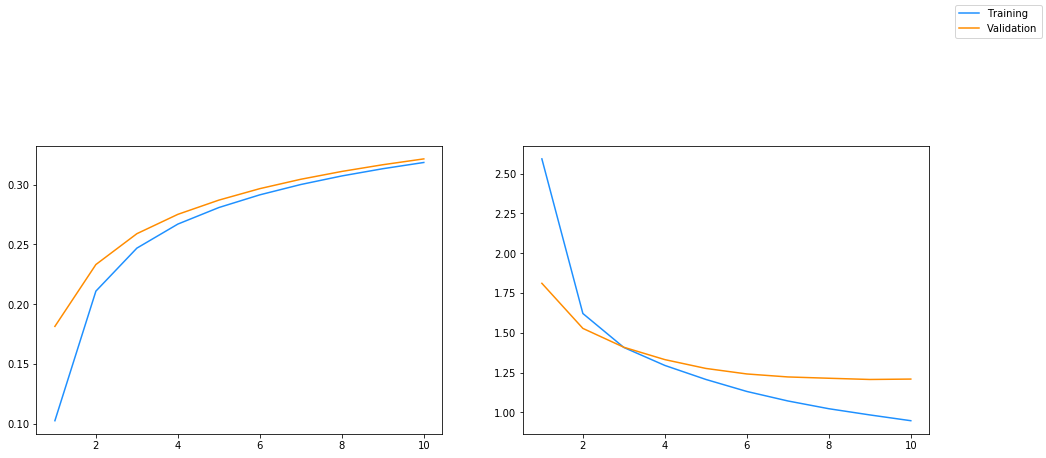

In [0]:
fig = plt.figure(figsize=(16, 8))

ax = fig.add_subplot(1,2,1)

ax.plot(range(1,EPOCHS+1), _acc, color='dodgerblue')
ax.plot(range(1,EPOCHS+1),_val_acc, color='darkorange')
ax.set_title('Accuracy')
ax1 = fig.add_subplot(1,2,2)

ax1.plot(range(1,EPOCHS+1), _loss, color='dodgerblue')
ax1.plot(range(1,EPOCHS+1),_val_loss, color='darkorange')
ax1.set_title('Loss')
fig.legend(['Training', 'Validation'])

plt.subplots_adjust(bottom=0.25, top=0.75)
plt.show()

## Inference

In [0]:
max_length_inp = pipeline.max_length_inp
max_length_targ = pipeline.max_length_targ


In [0]:
def evaluate(sentence):
    attention_plot = np.zeros((max_length_targ, max_length_inp))

    sentence = pipeline._preprocess_sentence(sentence)

    inputs = [input_tokenizer.word_index[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs],
                                                           maxlen=max_length_inp,
                                                           padding='post')
    inputs = tf.convert_to_tensor(inputs)

    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([target_tokenizer.word_index['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                             dec_hidden,
                                                             enc_out)

        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += target_tokenizer.index_word[predicted_id] + ' '

        if target_tokenizer.index_word[predicted_id] == '<end>':
            return result, sentence, attention_plot

        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [0]:

# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention.transpose(), cmap='Blues')

    fontdict = {'fontsize': 14}

    ax.set_yticklabels([''] + sentence, fontdict=fontdict)
    ax.set_xticklabels([''] + predicted_sentence, fontdict=fontdict, rotation=90)
    
    ax.set_ylabel('Input sequence')
    ax.set_xlabel('Output sequence')

    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    #plt.savefig('/content/drive/My Drive/Master Thesis/seq2seqAtn.png')
    plt.show()

In [0]:
def respond(sentence):
    result, sentence, attention_plot = evaluate(sentence)

    print('Input: %s' % (sentence))
    print('\nPredicted responses: {}'.format(result))

    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))


- Please cancel my account and remove all credit card information from your system.
- Please see attached copy of my drivers license for my Car2Go records.
- Hi there, Please find my proof of refuel purchase along with the car2go rental it applies to below.
- Car rental today - vehicle had warning light on that tire sensor was not working
- Hello, do you have a lost and found for items left in cars? I lost a scarf and Cab which are quite sentimental to me.
- Why am I not able to end my rental?

In [0]:
respond('Hi there, Please find my proof of refuel purchase along with the rental it applies to below.')

Input: <start> please see attached copy of my drivers license for my <company> records . <end>

Predicted responses: i’m happy to help ! however , i’m unable to find your <company> account with the information provided . per our privacy policy , i can’t disclose or change account information unless authorized by the account owner <end> 


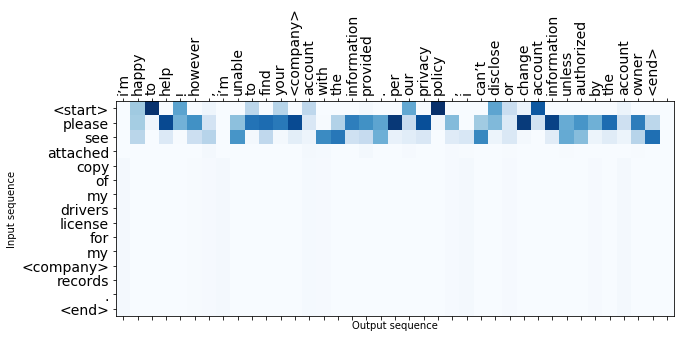

In [0]:

respond('Please see attached copy of my drivers license for my Car2Go records.')

In [0]:
respond('Hi there, Please find my proof of refuel purchase along with the rental it applies to below.')

Input: <start> hi there , during my car rental today vehicle i had warning light on that tire sensor was not working <end>

Predicted responses: thank you for the report ! i will send an agent from our service team to check it out as soon as possible . if you have any additional questions or concerns , please don't hesitate to contact us ! elsa --original message-- from: if you have any additional questions 


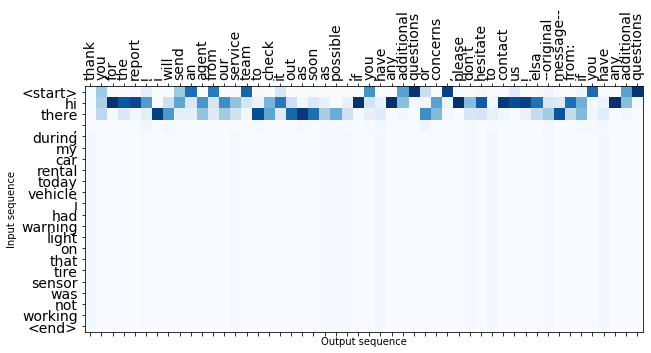

In [0]:
respond('Hi there, during my car rental today vehicle I had warning light on that tire sensor was not working')

Input: <start> hello , do you have a lost and found for items left in cars ? i lost a scarf and cab which are quite sentimental to me . <end>

Predicted responses: we would be more than happy to assist you in retrieving your lost belongings . unfortunately , nothing has been turned into our local office that matches the description of your belongings <end> 


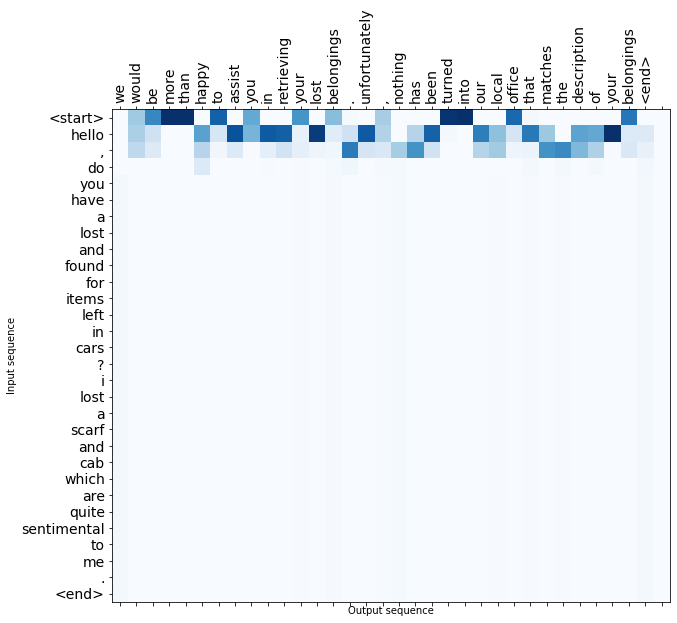

In [0]:
respond('Hello, do you have a lost and found for items left in cars? I lost a scarf and Cab which are quite sentimental to me.')

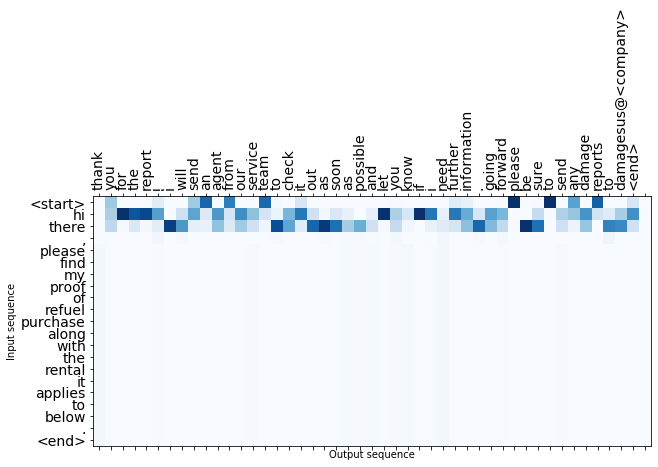

In [0]:
result, sentence, attention_plot = evaluate('Hi there, Please find my proof of refuel purchase along with the rental it applies to below.')

attention = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]

sentence = sentence.split(' ')

predicted_sentence = result.split(' ')

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(1, 1, 1)
ax.matshow(attention.transpose(), cmap='Blues')

fontdict = {'fontsize': 14}

ax.set_yticklabels([''] + sentence, fontdict=fontdict)
ax.set_xticklabels(['<start>'] + predicted_sentence, fontdict=fontdict, rotation=90)

ax.set_ylabel('Input sequence')
ax.set_xlabel('Output sequence')

ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
#plt.savefig('/content/drive/My Drive/Master Thesis/seq2seqAtn.png')
plt.show()

In [0]:
def preprocess_response(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = w.lower().strip()
    w = w.replace(' .','.').replace(' ,',',').replace(' !','!').replace(' ?','?').replace(' !','!')
    #w = re.sub(r"([?.!,¿])", r"\1", w)
    
    w = w.replace('<start> ','').replace(' <end>','')
    w = w.rstrip().strip()
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    #w = '<start> ' + w + ' <end>'
    return w

In [0]:
def get_response(output):
  #output: numpay array containing predicted word ids
  return  preprocess_response(' '.join([target_tokenizer.index_word[i] for i in output
                                            if i < len(target_tokenizer.word_index)]))
def get_input(input):
  #input: numpy array of ids of input
  return  preprocess_response(' '.join([input_tokenizer.index_word[i] for i in input
                                            if (i < len(input_tokenizer.word_index))
                                            & (i !=0) ]))
def get_truth(target):
  #target: numpy array of ids of actual response
  return  preprocess_response(' '.join([target_tokenizer.index_word[i] for i in target
                                            if (i < len(target_tokenizer.word_index))
                                            & (i !=0) ]))

In [0]:
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

In [0]:
from nltk.translate.bleu_score import sentence_bleu
from rouge import Rouge
from nltk.translate.meteor_score import meteor_score
calc_rouge = Rouge()
nltk.download('wordnet')


chencherry = nltk.translate.bleu_score.SmoothingFunction()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [0]:
def run_inference_greedy(test_dataset,decoder):

  test_enquiries = []
  bot_respones = []
  true_responses = []


  for (batch, (inpt, targt)) in enumerate(test_dataset):
    
    if batch % 5 == 0:
        print ('Batch {} '.format(batch))
    #Initialize hidden state with zeros
    hidden = [tf.zeros((inpt.shape[0], units))]

    enc_out, enc_hidden = encoder(inpt, hidden)

    dec_hidden = enc_hidden

    start_token = target_tokenizer.word_index['<start>']

    dec_input = tf.constant(np.repeat([start_token], inpt.shape[0]),shape=(inpt.shape[0],1))
    
    output = tf.cast(tf.zeros((inpt.shape[0], 1)),dtype=tf.int64)
    
    for t in range(max_length_targ):

            predictions, dec_hidden, attention_weights = decoder(dec_input,
                                                                 dec_hidden,
                                                                 enc_out)

            dec_input = tf.reshape(tf.argmax(predictions,axis=-1),shape=(64,1))
            if t==0:
                output = dec_input
            else:
                output = tf.concat([output,dec_input],axis=-1)

    [bot_respones.append(get_response(x)) for x in output.numpy()]
    [true_responses.append(get_truth(x)) for x in targt.numpy()]
    [test_enquiries.append(get_input(x)) for x in inpt.numpy()]

  bleus = []
  meteors = []
  rouges  = []
  for (a,b) in zip(bot_respones,true_responses):
    bleus.append(sentence_bleu([b.split(' ')],
                                  a.split(' '),smoothing_function=chencherry.method1))

    meteors.append(meteor_score([b],a))
    scores = calc_rouge.get_scores(b,a)
    rouges.append(scores[0]['rouge-1']['f'])

  
  df_result = pd.DataFrame({'BLEU':bleus,'ROUGE-1':rouges,'METEOR':meteors,'Enquiry':test_enquiries,'Bot':bot_respones,'True':true_responses})

  return df_result

In [0]:
df_test = run_inference_greedy(test_dataset,decoder)

Batch 0 
Batch 5 
Batch 10 
Batch 15 
Batch 20 
Batch 25 
Batch 30 
Batch 35 
Batch 40 
Batch 45 
Batch 50 
Batch 55 
Batch 60 
Batch 65 
Batch 70 
Batch 75 
Batch 80 
Batch 85 
Batch 90 
Batch 95 
Batch 100 
Batch 105 
Batch 110 
Batch 115 
Batch 120 
Batch 125 
Batch 130 
Batch 135 
Batch 140 
Batch 145 
Batch 150 
Batch 155 
Batch 160 
Batch 165 
Batch 170 
Batch 175 
Batch 180 
Batch 185 
Batch 190 
Batch 195 
Batch 200 
Batch 205 
Batch 210 
Batch 215 
Batch 220 
Batch 225 
Batch 230 
Batch 235 
Batch 240 
Batch 245 
Batch 250 
Batch 255 
Batch 260 
Batch 265 
Batch 270 
Batch 275 
Batch 280 
Batch 285 
Batch 290 
Batch 295 
Batch 300 
Batch 305 
Batch 310 
Batch 315 
Batch 320 
Batch 325 
Batch 330 
Batch 335 
Batch 340 
Batch 345 
Batch 350 


In [0]:
df_test.to_csv('/content/drive/My Drive/Master Thesis/seq2seq.csv')

In [0]:
df_test[['BLEU','ROUGE-1','METEOR']].mean()

In [0]:
def clean_classification(x):
  try:
    return re.sub(r"[^a-zA-Z&; ]+", "",x).replace('deleted','').replace('cargo','<company>').strip(' ')
  except:
    return x
    
    
data['CLASSIFICATIONS'] = [clean_classification(x) for x in data['CLASSIFICATIONS_x']]

In [0]:
  def preprocess_sentence(w,is_input=False):
      #w = unicode_to_ascii(w.lower().strip())

      # creating a space between a word and the punctuation following it
      # eg: "he is a boy." => "he is a boy ."
      # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
      w = w.lower().strip()
      w = re.sub(r"([?.!,¿])", r" \1 ", w)
      w = re.sub(r'[" "]+', " ", w)
      w = w.replace('\n', ' ').replace('\r', ' ').replace('\xa0',' ')
      if is_input == True:
      # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
        w = re.sub(r"[^a-zA-Z?.!,0-9]+", " ", w)
      w = w.replace('car2go','<company>')
      w = w.replace('Share Now','<company>')

      w = w.rstrip().strip()

      # adding a start and an end token to the sentence
      # so that the model know when to start and stop predicting.
      w = '<start> ' + w + ' <end>'
      return w


  def tokenize(corpus,tokenizer):
   
      tensor = tokenizer.texts_to_sequences(corpus)
      #tensor = [len(tokenizer.word_index)] + tensor + [len(tokenizer.word_index + 1)]
      #tensor = tf.convert_to_tensor(tensor)
      tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor,
                                                            padding='post',
                                                            maxlen=MAX_LENGTH)

      return tensor


  def get_training_data(inputs,targets):   
      enquiries = [preprocess_sentence(x,True) for x in inputs]
      replies = [preprocess_sentence(x) for x in targets]

      input_tensor = tokenize(enquiries,input_tokenizer)
      target_tensor = tokenize(replies,target_tokenizer)

      input_tensor_train, input_tensor_test, target_tensor_train, target_tensor_test = train_test_split(input_tensor, target_tensor, test_size=0.2)
      
      train_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(len(input_tensor_train))
            
      test_dataset = tf.data.Dataset.from_tensor_slices((input_tensor_test, target_tensor_test)).shuffle(len(input_tensor_test))

      return test_dataset

In [0]:
class_results = {}
for c in data['CLASSIFICATIONS'].value_counts()[:7].index:

  _test_dataset = get_training_data(inputs=data.loc[data['CLASSIFICATIONS']==c,'enquiry'].to_list()
                                        ,targets = data.loc[data['CLASSIFICATIONS']==c,'reply'].to_list())
  _test_dataset = _test_dataset.batch(BATCH_SIZE,drop_remainder=True)
  test_results = run_inference_greedy(_test_dataset,decoder)
  class_results.update({c : test_results[['BLEU','ROUGE-1','METEOR']]})

In [0]:
for c in class_results.keys():
  print(c+'\n',class_results[c].mean())